In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor
import re
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('reviews.csv')
df.shape

(48136, 15)

In [4]:
df.columns

Index(['age', 'body type', 'bust size', 'category', 'fit', 'height', 'item_id',
       'rating', 'rented for', 'review_date', 'review_summary', 'review_text',
       'size', 'user_id', 'weight'],
      dtype='object')

In [5]:
df.dtypes

age               float64
body type          object
bust size          object
category           object
fit                object
height             object
item_id             int64
rating            float64
rented for         object
review_date        object
review_summary     object
review_text        object
size                int64
user_id             int64
weight             object
dtype: object

From here we can see that there is multiple errors with our types - implying that there is incorrect data in some fields

In [6]:
df.describe(include="all")

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
count,47894.000000,44544,43567,48136,48136,47952,4.813600e+04,48116.000000,48133,48136,48136,48136,48136.000000,48136.000000,40594
unique,NaN,7,95,62,3,24,NaN,NaN,8,2120,41417,47935,NaN,NaN,173
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",b'Stylist Review',b'.',NaN,NaN,130lbs
freq,NaN,13887,6732,23179,35430,7100,NaN,NaN,14411,208,230,18,NaN,NaN,3576
mean,33.866580,NaN,NaN,NaN,NaN,NaN,1.043875e+06,9.084255,NaN,NaN,NaN,NaN,12.248255,499091.944470,NaN
std,8.018446,NaN,NaN,NaN,NaN,NaN,8.067556e+05,1.436092,NaN,NaN,NaN,NaN,8.523070,288853.095706,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.941820e+05,8.000000,NaN,NaN,NaN,NaN,8.000000,249516.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.458800e+05,10.000000,NaN,NaN,NaN,NaN,12.000000,498811.000000,NaN
75%,37.000000,NaN,NaN,NaN,NaN,NaN,1.678888e+06,10.000000,NaN,NaN,NaN,NaN,16.000000,749178.750000,NaN


This confirms some problems we saw with our types, as well as showing us that quite a few columns are missing.

From looking at the data set manually we can see that review_summary and review_text are both large blocks of text so we will drop those as they are useless.

We are also going to drop all rows with a missing value in any column

In [7]:
df.drop("review_summary", axis=1, inplace=True)
df.drop("review_text", axis=1, inplace=True)

df.dropna(subset=['age', 'body type', 'bust size', 'category', 'fit', 'height', 'item_id','rating', 'rented for', 'review_date','size', 'user_id', 'weight'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.describe(include="all")

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight
count,36677.000000,36677,36677,36677,36677,36677,3.667700e+04,36677.000000,36677,36677,36677.000000,36677.000000,36677
unique,NaN,7,88,61,3,24,NaN,NaN,8,2066,NaN,NaN,169
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",NaN,NaN,130lbs
freq,NaN,11051,5873,17625,26928,5513,NaN,NaN,10575,153,NaN,NaN,3237
mean,34.084822,NaN,NaN,NaN,NaN,NaN,1.050619e+06,9.078060,NaN,NaN,11.468632,498566.634485,NaN
std,8.032131,NaN,NaN,NaN,NaN,NaN,8.109600e+05,1.442064,NaN,NaN,7.857180,289344.763863,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.942320e+05,8.000000,NaN,NaN,4.000000,249049.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.543030e+05,10.000000,NaN,NaN,9.000000,498238.000000,NaN
75%,38.000000,NaN,NaN,NaN,NaN,NaN,1.687082e+06,10.000000,NaN,NaN,16.000000,748988.000000,NaN


Final dataset size = 36677, not so bad

Now we are going to find out all the unique values of the nominal features and see if we can find any problems

In [9]:
df["body type"].unique()

array(['athletic', 'full bust', 'petite', 'hourglass',
       'straight & narrow', 'pear', 'apple'], dtype=object)

Everything seems to be okay with body type

In [10]:
np.sort(df["bust size"].unique())

array(['28a', '28aa', '28b', '28c', '28d', '28dd', '28ddd/e', '28f',
       '30a', '30aa', '30b', '30c', '30d', '30dd', '30ddd/e', '30f',
       '30g', '30h', '32a', '32aa', '32b', '32c', '32d', '32d+', '32dd',
       '32ddd/e', '32f', '32g', '32h', '32j', '34a', '34aa', '34b', '34c',
       '34d', '34d+', '34dd', '34ddd/e', '34f', '34g', '34h', '36a',
       '36aa', '36b', '36c', '36d', '36d+', '36dd', '36ddd/e', '36f',
       '36g', '36h', '36i', '36j', '38a', '38aa', '38b', '38c', '38d',
       '38d+', '38dd', '38ddd/e', '38f', '38g', '38h', '38i', '38j',
       '40b', '40c', '40d', '40dd', '40ddd/e', '40f', '40g', '40h', '42b',
       '42c', '42d', '42dd', '42ddd/e', '42g', '44b', '44c', '44d',
       '44dd', '44ddd/e', '44f', '44g'], dtype=object)

<b>(TODO:) research these and make sure they are all valid values</b>

- 36d+ and 38d+ probably incorrect values

apart from that there are no outstandingly wrong values

In [11]:
np.sort(df["category"].unique())

array(['ballgown', 'blazer', 'blouse', 'blouson', 'bomber', 'buttondown',
       'cami', 'cape', 'cardigan', 'coat', 'combo', 'crewneck', 'culotte',
       'culottes', 'down', 'dress', 'duster', 'for', 'frock', 'gown',
       'henley', 'hoodie', 'jacket', 'jumpsuit', 'kaftan', 'kimono',
       'knit', 'legging', 'leggings', 'maxi', 'midi', 'mini', 'overalls',
       'pant', 'pants', 'parka', 'peacoat', 'poncho', 'print', 'pullover',
       'romper', 'sheath', 'shift', 'shirt', 'shirtdress', 'skirt',
       'skirts', 'skort', 'suit', 'sweater', 'sweatshirt', 't-shirt',
       'tank', 'tee', 'top', 'trench', 'trouser', 'trousers', 'tunic',
       'turtleneck', 'vest'], dtype=object)

Number of problems here:

- culotte (11) = culottes (41)
- down (88) ? *seems to be it's own thing
- for (1) ?
- legging (19) = leggings (22)
- midi (10) probably = mini (363)
- pant (20) = pants (86)
- shift (1004) probably = shirt (50) !! <b>it is not ; shift is a kind of dress</b>
- skirt (312) = skirts (2) = skort (2)
- t-shirt (3) probably = tee (6) probably = top (986)
- trouser (13) = trousers (4)

we are going to check the number of values of each of these that we see as incorrect, to confirm that they are wrong, then replace with what we believe to be the real values

In [12]:
df.loc[df.category == "culotte", "category"] = "culottes"
df.loc[df.category == "legging", "category"] = "leggings"
df.loc[df.category == "midi", "category"] = "mini"
df.loc[df.category == "pant", "category"] = "pants"
df.loc[df.category == "skirts", "category"] = "skirt"
df.loc[df.category == "skort", "category"] = "skirt"
df.loc[df.category == "t-shirt", "category"] = "top"
df.loc[df.category == "tee", "category"] = "top"
df.loc[df.category == "trousers", "category"] = "trouser"

In [13]:
for value in np.sort(df["category"].unique()).tolist():
    print("category: %s count: %i" % (value, (df[df["category"] == value].count())[1]))

category: ballgown count: 3
category: blazer count: 136
category: blouse count: 121
category: blouson count: 1
category: bomber count: 29
category: buttondown count: 1
category: cami count: 4
category: cape count: 21
category: cardigan count: 51
category: coat count: 173
category: combo count: 1
category: crewneck count: 1
category: culottes count: 52
category: down count: 88
category: dress count: 17625
category: duster count: 4
category: for count: 1
category: frock count: 39
category: gown count: 8316
category: henley count: 1
category: hoodie count: 3
category: jacket count: 449
category: jumpsuit count: 974
category: kaftan count: 7
category: kimono count: 7
category: knit count: 9
category: leggings count: 41
category: maxi count: 680
category: mini count: 373
category: overalls count: 2
category: pants count: 106
category: parka count: 3
category: peacoat count: 12
category: poncho count: 12
category: print count: 18
category: pullover count: 10
category: romper count: 641
categ

There are quite a few categories here that are that have a very low count so we will <b>consider dropping these with counts less that 100<b>

In [14]:
df["fit"].unique()

array(['fit', 'large', 'small'], dtype=object)

In [15]:
df["height"].unique()

array(['5\' 6"', '5\' 5"', '5\' 3"', '5\' 7"', '5\' 4"', '5\' 1"',
       '5\' 2"', '5\' 8"', '5\' 10"', '5\' 9"', '5\' 11"', '5\' 0"',
       '4\' 11"', '6\' 2"', '6\' 0"', '4\' 10"', '6\' 1"', '4\' 9"',
       '4\' 8"', '4\' 7"', '4\' 6"', '6\' 3"', '6\' 6"', '6\' 4"'],
      dtype=object)

Height must be changed to an integer value

In [16]:
df["rented for"].unique()

array(['everyday', 'wedding', 'work', 'other', 'formal affair', 'party',
       'date', 'vacation'], dtype=object)

In [17]:
df["weight"].unique()

array(['140lbs', '128lbs', '132lbs', '125lbs', '150lbs', '110lbs',
       '134lbs', '120lbs', '130lbs', '117lbs', '145lbs', '170lbs',
       '135lbs', '137lbs', '100lbs', '138lbs', '127lbs', '165lbs',
       '142lbs', '147lbs', '141lbs', '236lbs', '160lbs', '156lbs',
       '108lbs', '210lbs', '121lbs', '155lbs', '118lbs', '115lbs',
       '168lbs', '104lbs', '136lbs', '190lbs', '200lbs', '185lbs',
       '103lbs', '133lbs', '175lbs', '50lbs', '195lbs', '123lbs',
       '151lbs', '105lbs', '129lbs', '99lbs', '230lbs', '144lbs',
       '112lbs', '205lbs', '119lbs', '116lbs', '101lbs', '172lbs',
       '111lbs', '180lbs', '124lbs', '126lbs', '178lbs', '188lbs',
       '174lbs', '122lbs', '158lbs', '109lbs', '98lbs', '90lbs', '143lbs',
       '106lbs', '131lbs', '148lbs', '146lbs', '113lbs', '161lbs',
       '95lbs', '114lbs', '149lbs', '169lbs', '220lbs', '159lbs',
       '196lbs', '152lbs', '163lbs', '107lbs', '189lbs', '167lbs',
       '153lbs', '206lbs', '166lbs', '157lbs', '201lbs', 

weight must be changed to an integer

In [18]:
def stripLbs(string):
    if string and isinstance(string, str):
        string = string[:-3]
        return int(string.strip()) * 0.45359237
    else:
        return string
    
df["weight"] = df["weight"].apply(stripLbs)

In [19]:
df.describe(include="all") #someone is only 50 pounds??

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight
count,36677.000000,36677,36677,36677,36677,36677,3.667700e+04,36677.000000,36677,36677,36677.000000,36677.000000,36677.000000
unique,NaN,7,88,52,3,24,NaN,NaN,8,2066,NaN,NaN,NaN
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",NaN,NaN,NaN
freq,NaN,11051,5873,17625,26928,5513,NaN,NaN,10575,153,NaN,NaN,NaN
mean,34.084822,NaN,NaN,NaN,NaN,NaN,1.050619e+06,9.078060,NaN,NaN,11.468632,498566.634485,62.278070
std,8.032131,NaN,NaN,NaN,NaN,NaN,8.109600e+05,1.442064,NaN,NaN,7.857180,289344.763863,9.802242
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,0.000000,47.000000,22.679619
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.942320e+05,8.000000,NaN,NaN,4.000000,249049.000000,55.791862
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.543030e+05,10.000000,NaN,NaN,9.000000,498238.000000,61.234970
75%,38.000000,NaN,NaN,NaN,NaN,NaN,1.687082e+06,10.000000,NaN,NaN,16.000000,748988.000000,67.131671


In [20]:
def heightToMeters(string):
    if string and isinstance(string, str):
        string = string.replace(" ", "")
        pattern = r'([0-9])\'(.*)\"'
        reg = re.search(pattern, string)
        feet = int(reg.group(1))
        inches = int(reg.group(2))
        return 0.0254 * ((feet * 12) + inches)
    else:
        return string
    
df["height"] = df["height"].apply(heightToMeters)

In [21]:
df.describe(include="all")

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight
count,36677.000000,36677,36677,36677,36677,36677.000000,3.667700e+04,36677.000000,36677,36677,36677.000000,36677.000000,36677.000000
unique,NaN,7,88,52,3,NaN,NaN,NaN,8,2066,NaN,NaN,NaN
top,NaN,hourglass,34b,dress,fit,NaN,NaN,NaN,wedding,"June 15, 2016",NaN,NaN,NaN
freq,NaN,11051,5873,17625,26928,NaN,NaN,NaN,10575,153,NaN,NaN,NaN
mean,34.084822,NaN,NaN,NaN,NaN,1.657547,1.050619e+06,9.078060,NaN,NaN,11.468632,498566.634485,62.278070
std,8.032131,NaN,NaN,NaN,NaN,0.067261,8.109600e+05,1.442064,NaN,NaN,7.857180,289344.763863,9.802242
min,0.000000,NaN,NaN,NaN,NaN,1.371600,1.233730e+05,2.000000,NaN,NaN,0.000000,47.000000,22.679619
25%,29.000000,NaN,NaN,NaN,NaN,1.600200,1.942320e+05,8.000000,NaN,NaN,4.000000,249049.000000,55.791862
50%,32.000000,NaN,NaN,NaN,NaN,1.651000,9.543030e+05,10.000000,NaN,NaN,9.000000,498238.000000,61.234970
75%,38.000000,NaN,NaN,NaN,NaN,1.701800,1.687082e+06,10.000000,NaN,NaN,16.000000,748988.000000,67.131671


In [22]:
df.shape

(36677, 13)

Still a few more problems here now:
 - someone is aged 117 and 0 ; considering only 7 people have ever lived to 117 this is probably wrong -> these are wrong
 - someone is 4'6" ; possible - must look into that row -> all seem reasonable
 - someone weighs 50 pounds - nearly impossible for someone to weigh under 80 pounds
 - someone weighs 285 pounds (120kg) - all values seem reasonable, tall people taking large sizes
 - something is size 58 - not really sure sizes are fucked

In [23]:
df = df[((df["age"] < 100) & (df["age"] > 14)) & (df["weight"] > 37)]
df.reset_index(drop=True, inplace=True)
df.describe(include="all")

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight
count,36651.000000,36651,36651,36651,36651,36651.000000,3.665100e+04,36651.000000,36651,36651,36651.000000,36651.000000,36651.000000
unique,NaN,7,88,52,3,NaN,NaN,NaN,8,2066,NaN,NaN,NaN
top,NaN,hourglass,34b,dress,fit,NaN,NaN,NaN,wedding,"June 15, 2016",NaN,NaN,NaN
freq,NaN,11043,5872,17616,26909,NaN,NaN,NaN,10566,153,NaN,NaN,NaN
mean,34.080762,NaN,NaN,NaN,NaN,1.657541,1.050718e+06,9.078006,NaN,NaN,11.467600,498527.237320,62.282721
std,7.930013,NaN,NaN,NaN,NaN,0.067253,8.109654e+05,1.442334,NaN,NaN,7.853231,289365.857366,9.791460
min,15.000000,NaN,NaN,NaN,NaN,1.371600,1.233730e+05,2.000000,NaN,NaN,0.000000,47.000000,39.008944
25%,29.000000,NaN,NaN,NaN,NaN,1.600200,1.942320e+05,8.000000,NaN,NaN,4.000000,248985.500000,56.245454
50%,32.000000,NaN,NaN,NaN,NaN,1.651000,9.543030e+05,10.000000,NaN,NaN,9.000000,498047.000000,61.234970
75%,38.000000,NaN,NaN,NaN,NaN,1.701800,1.687082e+06,10.000000,NaN,NaN,16.000000,748907.000000,67.131671


<h1>Converting review_date to numeric</h1>
    
  - find oldest date
    -set that to 0
  - every subsequent day + 1 -> probably a bad idea right?
  - split dates into columns: year, month, day, weekend, season : pandas has function for that
    - look for correlations here
    
  - we know there is no NaN "df["review_date"].isna().unique()"

In [75]:
df["review_date"] = pd.to_datetime(df["review_date"])

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight,torso size,bmi,year
count,36651.000000,36651,36651,36651,36651,36651.000000,36651,36651.000000,36651,36651,36651.000000,36651,36651.000000,36651.000000,36651.000000,36651.000000
unique,NaN,7,88,52,3,NaN,4726,NaN,8,2066,NaN,27659,NaN,NaN,NaN,NaN
top,NaN,hourglass,34b,dress,fit,NaN,126335,NaN,wedding,2016-06-15 00:00:00,NaN,691468,NaN,NaN,NaN,NaN
freq,NaN,11043,5872,17610,26909,NaN,391,NaN,10566,153,NaN,96,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.080762,NaN,NaN,NaN,NaN,1.657541,NaN,9.078006,NaN,NaN,11.467600,NaN,62.282721,34.107664,22.668790,2015.677171
std,7.930013,NaN,NaN,NaN,NaN,0.067253,NaN,1.442334,NaN,NaN,7.853231,NaN,9.791460,1.704077,3.324804,1.337366
min,15.000000,NaN,NaN,NaN,NaN,1.371600,NaN,2.000000,NaN,NaN,0.000000,NaN,39.008944,28.000000,14.976630,2011.000000
25%,29.000000,NaN,NaN,NaN,NaN,1.600200,NaN,8.000000,NaN,NaN,4.000000,NaN,56.245454,32.000000,20.484858,2015.000000


In [80]:
bus_days = pd.bdate_range(df['review_date'].min(), df['review_date'].max())
df['business_day'] = df['review_date'].isin(bus_days)
df['year'] = (df["review_date"].apply(lambda x: x.year)).astype(str)
df['month'] = (df["review_date"].apply(lambda x: x.month)).astype(str)
df['day'] = (df["review_date"].apply(lambda x: x.day)).astype(str)
df.describe(include="all")

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight,torso size,bmi,year,business_day,month,day
count,36651.000000,36651,36651,36651,36651,36651.000000,36651,36651.000000,36651,36651,36651.000000,36651,36651.000000,36651.000000,36651.000000,36651,36651,36651,36651
unique,NaN,7,88,52,3,NaN,4726,NaN,8,2066,NaN,27659,NaN,NaN,NaN,8,2,12,31
top,NaN,hourglass,34b,dress,fit,NaN,126335,NaN,wedding,2016-06-15 00:00:00,NaN,691468,NaN,NaN,NaN,2017,True,10,15
freq,NaN,11043,5872,17610,26909,NaN,391,NaN,10566,153,NaN,96,NaN,NaN,NaN,12956,30386,3898,1363
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.080762,NaN,NaN,NaN,NaN,1.657541,NaN,9.078006,NaN,NaN,11.467600,NaN,62.282721,34.107664,22.668790,NaN,NaN,NaN,NaN
std,7.930013,NaN,NaN,NaN,NaN,0.067253,NaN,1.442334,NaN,NaN,7.853231,NaN,9.791460,1.704077,3.324804,NaN,NaN,NaN,NaN
min,15.000000,NaN,NaN,NaN,NaN,1.371600,NaN,2.000000,NaN,NaN,0.000000,NaN,39.008944,28.000000,14.976630,NaN,NaN,NaN,NaN
25%,29.000000,NaN,NaN,NaN,NaN,1.600200,NaN,8.000000,NaN,NaN,4.000000,NaN,56.245454,32.000000,20.484858,NaN,NaN,NaN,NaN


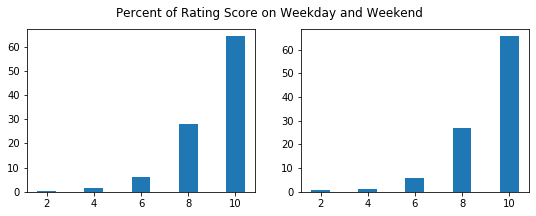

In [194]:
df_true = df[df["business_day"] == True]
df_false = df[df["business_day"] == False]
values = [2.0,4.0,6.0,8.0,10.0]
weekday_counts = [((df_true['rating'].value_counts()[x] / df_true["rating"].count()) * 100) for x in values]
weekend_counts = [((df_false['rating'].value_counts()[x] / df_false["rating"].count()) * 100) for x in values]
#plotting percentage of ratings versus on the weekend or not
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.title = "Weekday"
plt.bar(values, weekday_counts)
plt.subplot(122)
plt.title = "Weekend"
plt.bar(values, weekend_counts)
plt.suptitle('Percent of Rating Score on Weekday and Weekend')
plt.show()

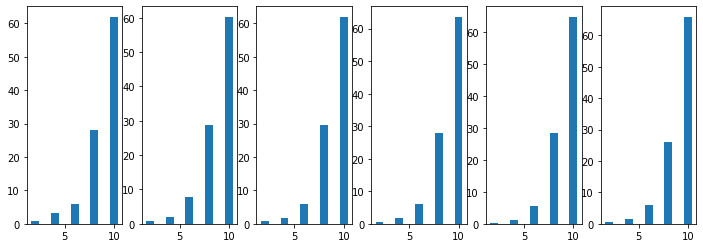

In [189]:
df_11 = df[df["year"] == "2011"]
df_12 = df[df["year"] == "2012"]
df_13 = df[df["year"] == "2013"]
df_14 = df[df["year"] == "2014"]
df_15 = df[df["year"] == "2015"]
df_16 = df[df["year"] == "2016"]
df_17 = df[df["year"] == "2017"]
df_18 = df[df["year"] == "2018"]
dataframes = [df_12, df_13, df_14, df_15, df_16, df_17]
count = 161
values = [2.0,4.0,6.0,8.0,10.0]
plt.figure(figsize=(12, 4))
for frame in dataframes:
    amount = [((frame['rating'].value_counts()[x] / frame["rating"].count()) * 100) for x in values]
    plt.subplot(count)
    plt.bar(values, amount)
    count += 1
plt.show()

<h2> Aside 1: Producing Clean Dataframes</h2>

Okay so I am fairly certain that the steps we have taken up until this point, <i>apart</i> from dropping all NaN values, are steps we should do to almost every dataframe we work with past this point so I am quickly going to define a function that will do all of these steps for us so we are not rewriting the same code over and over.

In [108]:
def getCleanDF(dropAllNan=False, delReview=True, hgtToNum=True, wgtToNum=True, fixBust=True, fixCtgrs=True, delBadValues=True, nrmIds=True, cvrtDate=True):
    df = pd.read_csv('reviews.csv')
    #drop all rows without a label
    df.dropna(subset=['rating'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    if dropAllNan:
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
    if delReview: #drop the columns with review text
        df.drop("review_summary", axis=1, inplace=True)
        df.drop("review_text", axis=1, inplace=True)
        df.reset_index(drop=True, inplace=True)
    if fixCtgrs: #replace all category values we are viewing as typos
        df.loc[df.category == "culotte", "category"] = "culottes"
        df.loc[df.category == "legging", "category"] = "leggings"
        df.loc[df.category == "midi", "category"] = "mini"
        df.loc[df.category == "pant", "category"] = "pants"
        df.loc[df.category == "skirts", "category"] = "skirt"
        df.loc[df.category == "skort", "category"] = "skirt"
        df.loc[df.category == "t-shirt", "category"] = "top"
        df.loc[df.category == "tee", "category"] = "top"
        df.loc[df.category == "trousers", "category"] = "trouser"
    #convert height and weight to numeric features
    if wgtToNum:
        df["weight"] = df["weight"].apply(stripLbs)
    if hgtToNum:
        df["height"] = df["height"].apply(heightToMeters)
    if delBadValues: #remove rows values in age and weight we see as incorrect/typos
        df = df[(df["age"].isna()) | ((df["age"] < 100) & (df["age"] > 14))]
        df = df[(df["weight"].isna()) | (df["weight"] > 37)] #TODO: combine these booleans into one
        df.reset_index(drop=True, inplace=True)
    if nrmIds: #makking items with same id have same category
        df.loc[df.item_id == "2245184", "category"] = "top"
        df.loc[df.item_id == "2524821", "category"] = "top"
        df.loc[df.item_id == "1788819", "category"] = "maxi"
    if cvrtDate:
        df["review_date"] = pd.to_datetime(df["review_date"])
    return df

<h1>Model Alpha - Removing NaN Values</h1>

<h2>Alpha V.0 - dropping item_id, review_date, user_id</h2>

In [109]:
#first model
# The features we want to select
num_ft_alpha0_0 = ["age", "height", "size", "weight"]
nom_ft_alpha0_0 = ["body type", "category", "fit", "rented for", "bust size"]
#dropping item_id review_date user_id

# Create the pp
pp_alpha0_0 = ColumnTransformer([("num", StandardScaler(), num_ft_alpha0_0),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft_alpha0_0)],
                                    remainder="drop")
# Create a pipe that combines the pp with the estimator
pipe_alpha0_0 = Pipeline([("pre", pp_alpha0_0),("est", LinearRegression())])

y = df["rating"].values

# Create the object that splits the data
kf = KFold(n_splits=10)
# Run the pipe
np.mean(cross_val_score(pipe_alpha0_0, df, y, scoring="neg_mean_absolute_error",
cv=kf))

-1.0978846244641527

<h2>Alpha V.0.1 - Running PCA on 2 features</h2>

In [110]:
#now we try running first model with PCA
pp_with_PCA = ColumnTransformer([("num", PCA(n_components=2), num_ft_alpha0_0),
("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft_alpha0_0)],remainder="drop")
pipe_with_PCA = Pipeline([("pre", pp_with_PCA),("est", LinearRegression())])

np.mean(cross_val_score(pipe_with_PCA, df, y, scoring="neg_mean_absolute_error",
cv=kf))

-1.097963466872646

A slightly better result assuming height-weight-age are correlated
Probably not going to use PCA on our features right now *changes are due to shuffles being different

<h2>Alpha V.1 - Not dropping any features</h2>

In [111]:
#a re-run of the first model, this time not dropping features
#perhaps items with a certain id was bady reviewed by multiple people - should be nominal
#users of certain id could be prone to giving certain scores - should be nominal
#perhaps users leave better reviews the later in the year it is/what time of year it is, ect.
num_ft_alpha1_0 = ["age", "height", "size", "weight", "user_id", "item_id"]
nom_ft_alpha1_0 = ["body type", "category", "fit", "rented for", "bust size", "review_date"]
pp_alpha1_0 = ColumnTransformer([("num", StandardScaler(), num_ft_alpha1_0),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft_alpha1_0)],
                                    remainder="drop")
pipe_alpha1_0 = Pipeline([("pre", pp_alpha1_0),("est", LinearRegression())])

np.mean(cross_val_score(pipe_alpha1_0, df, y, scoring="neg_mean_absolute_error",
cv=kf))

-1.0929627621625833

again a very marginal improvement, implying that some of these features do have influence over the estimation 
*changes are due to shuffles being different

<h2>Alpha V.2 - user_id, item_id as Nominal Features</h2>

In [112]:
#first model, this time converting user_id and item_id to nominal features
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)

df.describe(include="all")

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,size,user_id,weight,torso size,bmi,year,business_day,month,day
count,36651.000000,36651,36651,36651,36651,36651.000000,36651,36651.000000,36651,36651,36651.000000,36651,36651.000000,36651.000000,36651.000000,36651,36651,36651,36651
unique,NaN,7,88,52,3,NaN,4726,NaN,8,2066,NaN,27659,NaN,NaN,NaN,8,2,12,31
top,NaN,hourglass,34b,dress,fit,NaN,126335,NaN,wedding,2016-06-15 00:00:00,NaN,691468,NaN,NaN,NaN,2017,True,10,15
freq,NaN,11043,5872,17610,26909,NaN,391,NaN,10566,153,NaN,96,NaN,NaN,NaN,12956,30386,3898,1363
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.080762,NaN,NaN,NaN,NaN,1.657541,NaN,9.078006,NaN,NaN,11.467600,NaN,62.282721,34.107664,22.668790,NaN,NaN,NaN,NaN
std,7.930013,NaN,NaN,NaN,NaN,0.067253,NaN,1.442334,NaN,NaN,7.853231,NaN,9.791460,1.704077,3.324804,NaN,NaN,NaN,NaN
min,15.000000,NaN,NaN,NaN,NaN,1.371600,NaN,2.000000,NaN,NaN,0.000000,NaN,39.008944,28.000000,14.976630,NaN,NaN,NaN,NaN
25%,29.000000,NaN,NaN,NaN,NaN,1.600200,NaN,8.000000,NaN,NaN,4.000000,NaN,56.245454,32.000000,20.484858,NaN,NaN,NaN,NaN


Here we can see that there is only 4726 items so perhaps this will work

Users however we can see that there is ~9000 reviews made by a non-new user, not as good

We will still run though we may have dimensionality problems One-Hot Encoding so many variations on our nominal features

In [113]:
num_ft_alpha2_0 = ["age", "height", "size", "weight"]
nom_ft_alpha2_0 = ["body type", "category", "fit", "rented for", "bust size", "review_date", "user_id", "item_id"]
pp_alpha2_0 = ColumnTransformer([("num", StandardScaler(), num_ft_alpha2_0),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft_alpha2_0)],
                                    remainder="drop")
pipe_alpha2_0 = Pipeline([("pre", pp_alpha2_0),("est", LinearRegression())])

#np.mean(cross_val_score(pipe, df, y, scoring="neg_mean_absolute_error",cv=kf))
#this takes fucking ages to run

We have now increased our score by a signifigant amountt

This time we will try our first model except with just item_id as a nominal feature as there was a lot of user IDs and that many columns will surely have an affect on our accuracy
<h2>Alpha V.2.1  - item_id as Nominal Feature, dropping user_id</h2>

In [114]:
nom_ft_alpha2_1 = ["body type", "category", "fit", "rented for", "bust size","item_id"]
num_ft_alpha2_1 = num_ft_alpha2_0
pp_alpha2_1 = ColumnTransformer([("num", StandardScaler(), num_ft_alpha2_1),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft_alpha2_1)],
                                    remainder="drop")
pipe_alpha2_1 = Pipeline([("pre", pp_alpha2_1),("est", LinearRegression())])

np.mean(cross_val_score(pipe_alpha2_1, df, y, scoring="neg_mean_absolute_error",
cv=kf))

-1.0983119253400389

A marginal decrease in score here, unfortunate as we were hoping that items sharing an id may have similar review scores

<h2>Aside 2: Cleaning Rows with Matching IDs to have Matching Categories</h2>
After taking a look at the *relatively* limited amount of item_ids, I was interested in finding out if rows that share an item_id have any discrepancies in the category feature

In [115]:
#list_of_ids = [] #list of ids where categories don't match up
#for i in range(len(df["item_id"].unique())):
    #if len(df[df["item_id"] == df["item_id"].unique()[i]]["category"].unique()) > 1:
        #list_of_ids.append(df["item_id"].unique()[i])
#list_of_ids
#this code really needs to be cleaned up IT IS SO SLOW

In [116]:
#df[df["item_id"] == '2245184']

In [117]:
df.loc[df.item_id == "2245184", "category"] = "top"
#df[df["item_id"] == '2245184']

In [118]:
#df[df["item_id"] == '2524821']

In [119]:
df.loc[df.item_id == "2524821", "category"] = "top"
#df[df["item_id"] == '2524821']

In [120]:
#df[df["item_id"] == '1788819']

In [121]:
df.loc[df.item_id == "1788819", "category"] = "maxi"
#df[df["item_id"] == '1788819']

<b>TODO: clean up all the above, remove the describes and optimize code, probably run the models with item_id having matching categories, also maybe add to cleanDF function</b>

<h2>Alpha V.2.1.1  - item_id as Nominal Feature, dropping user_id with categories fixed</h2>

In [122]:
y = df["rating"].values
nom_ft_alpha2_1_1 = ["body type", "category", "fit", "rented for", "bust size","item_id"]
num_ft_alpha2_1_1 = ["age", "height", "size", "weight"]
pp_alpha2_1_1 = ColumnTransformer([("num", StandardScaler(), num_ft_alpha2_1_1),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft_alpha2_1_1)],
                                    remainder="drop")
pipe_alpha2_1_1 = Pipeline([("pre", pp_alpha2_1_1),("est", LinearRegression())])
np.mean(cross_val_score(pipe_alpha2_1_1, df, y, scoring="neg_mean_absolute_error",
cv=kf))

-1.0983119253400389

In [123]:
def getTorso(bustSize):
    if bustSize and isinstance(bustSize, str):
        bustSize = bustSize.replace(" ", "")
        pattern = r'(\d*).*'
        reg = re.search(pattern, bustSize)
        return int(reg.group(1))
    else:
        return bustSize
    
df["torso size"] = df["bust size"].apply(getTorso)
y = df["rating"].values
nom_ft = ["body type", "category", "fit", "rented for","item_id"]
num_ft = ["age", "height", "size", "weight", "torso size"]
pp = ColumnTransformer([("num", StandardScaler(), num_ft),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft)],
                                    remainder="drop")
pipe = Pipeline([("pre", pp),("est", LinearRegression())])
np.mean(cross_val_score(pipe, df, y, scoring="neg_mean_absolute_error",
cv=kf))

KeyboardInterrupt: 

In [ ]:
y = df["rating"].values
nom_ft = ["body type", "category", "fit", "rented for"]
num_ft = ["age", "height", "size", "weight", "torso size"]
pp = ColumnTransformer([("num", StandardScaler(), num_ft),
                                  ("nom", OneHotEncoder(handle_unknown="ignore"), nom_ft)],
                                    remainder="drop")
pipe = Pipeline([("pre", pp),("est", LinearRegression())])
np.mean(cross_val_score(pipe, df, y, scoring="neg_mean_absolute_error",
cv=kf))

<h1>Correlation between values</h1>

In [ ]:
#scatter_matrix(df, figsize=(15, 15))

In [ ]:
df["bmi"] = df["weight"] / (df["height"]**2)
plt.scatter(df["bmi"], df["size"])
plt.show()

In [ ]:
scaler = MinMaxScaler()
num_fts = ["age", "weight", "height", "bmi", "size", "torso size"]
data = df[num_fts]
pca = PCA().fit(data)
pca.explained_variance_ratio_

<h1>Model Beta</h1>

Whereas in Model Alpha we were removing all NaN values, for Model Beta we are going to impute NaN values and compare with Model Alpha

<h2>Version 0</h2>
 - here we are going to impute as many nan values as possible with SimpleImputer

In [ ]:
df_new = getCleanDF()
df_new.describe(include="all")

In [ ]:
num_ft = ["age", "height", "size", "weight", "item_id", "user_id"]
nom_ft = ["body type", "category", "fit", "rented for", "bust size", "review_date"]

pp = ColumnTransformer(
    [("num",
      Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),("scaler", StandardScaler())]), num_ft),
    ("nom",
     Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),("binarizer", OneHotEncoder(handle_unknown="ignore"))]),
     nom_ft)], remainder="drop")
, random_state=0
pipe = Pipeline([("pre", pp),("est", LinearRegression())])

y = df_new["rating"].values

kf = KFold(n_splits=10)
np.mean(cross_val_score(pipe, df_new, y, scoring="neg_mean_absolute_error",cv=kf))

Okay so the SimpleImputer as the name would suggest is very basic, only taking the mean or mode of a feature, if at all possible we want something a bit more indepth. We are going to try use IterativeImputer now to get a more comprehensive value out of the imputation and see if that will affect our score at all.

<h2>Version 1.0 - Iterative Imputer</h2>

*I know we are depending a lot on how good IterativeImputer performs and it does state that in the documentation that this function is still in an experimental stage but we will still try

In [ ]:
iterative_pp = ColumnTransformer(
    [("nom",
     Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),("binarizer", OneHotEncoder(handle_unknown="ignore"))]),
     nom_ft),
    ("num",
      Pipeline([("imputer", IterativeImputer(missing_values=np.nan, random_state=0, sample_posterior=True, max_iter=10)),("scaler", StandardScaler())]), num_ft)
    ], remainder="drop")
iterative_pipe = Pipeline([("pre", iterative_pp),("est", LinearRegression())])

np.mean(cross_val_score(iterative_pipe, df_new, y, scoring="neg_mean_absolute_error",cv=kf))

There is a tiny differenence between our iteratively imputed values versus the values imputed with SimpleImputer, there could be a multitude of reasons as to why the difference is so low
    - the wrong kind of regressor is used to predict imputed values
    - the values being imputed are being compared with a lot of other values which have been imputed, hence a lot of guesswork going on
    - the IterativeImputer itself is not very good
    
Instead of messing around more with iterative imputation we are just going to stick with SimpleImputation for the moment then

<h2> Beta V 0.1 - Simple Imputation dropping review_date, user_id and item_id </h2>

In [ ]:
num_ft = ["age", "height", "size", "weight"]
nom_ft = ["body type", "category", "fit", "rented for", "bust size"]

pp = ColumnTransformer(
    [("num",
      Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),("scaler", StandardScaler())]), num_ft),
    ("nom",
     Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),("binarizer", OneHotEncoder(handle_unknown="ignore"))]),
     nom_ft)], remainder="drop")
, random_state=0
pipe = Pipeline([("pre", pp),("est", LinearRegression())])
np.mean(cross_val_score(pipe, df_new, y, scoring="neg_mean_absolute_error",cv=kf))

In [ ]:
def getTorso(bustSize):
    if bustSize and isinstance(bustSize, str):
        bustSize = bustSize.replace(" ", "")
        pattern = r'(\d*).*'
        reg = re.search(pattern, bustSize)
        return int(reg.group(1))
    else:
        return bustSize

df_new["torso width"] = df_new["bust size"].apply(getTorso)
num_ft = ["age", "height", "size", "weight", "torso width"]
nom_ft = ["body type", "category", "fit", "rented for"]

pp = ColumnTransformer(
    [("num",
      Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),("scaler", StandardScaler())]), num_ft),
    ("nom",
     Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),("binarizer", OneHotEncoder(handle_unknown="ignore"))]),
     nom_ft)], remainder="drop")
, random_state=0
pipe = Pipeline([("pre", pp),("est", LinearRegression())])
np.mean(cross_val_score(pipe, df_new, y, scoring="neg_mean_absolute_error",cv=kf))